Notes

In [5]:
import pandas
from modsim import *

Questions:

- Why was there a population rise in Germany between 1950-1970?
    - What was the effect on the population of Portugal (one of the 7 locations where migrant workers were coming to Germany from) during this time?

Our System:
- Germany and Portugal (1951-2015)

Our Model:
- Create a model where we have some people migrate to Germany and leave after 3 years
- Create a model where we have some people migrate from Portugal and return after 3 years


In [6]:
rows = 64

ger_port_data = pandas.read_csv('germany_portugal.csv', 
                               low_memory=False, 
                               usecols=[0, 1, 2], 
                               nrows=rows, 
                               index_col=0)

#Import data from saved CSV file

In [7]:
germany = ger_port_data.Germany / 1e6
portugal = ger_port_data.Portugal / 1e6

#Save data from DataFrame, in ten millions

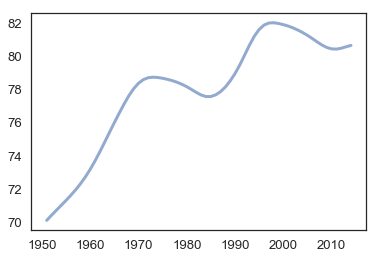

In [8]:
plot(germany)

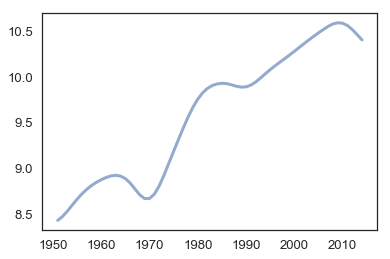

In [9]:
plot(portugal)

In [10]:
tg_0=get_first_label(germany)
tg_end=get_last_label(germany)
pg_0=get_first_value(germany) #Initialize German state values

tp_0=get_first_label(portugal)
tp_end=get_last_label(portugal)
pp_0=get_first_value(portugal) #Initialize Russian state values

In [96]:
system=System(tg_0=tg_0,       #Initialize system object
             tg_end=tg_end,    #Note: state object is initialized in
             pg_0=pg_0,        #run_simulation method
             tp_0=tp_0,
             tp_end=tp_end,
             pp_0=pp_0,
             maxG=85,
             maxP=12,
             aG=.00035,
             aP=.0015, 
             c = 1.2)            #c controls how popular the migrant worker program is

In [30]:
def update_func_quad_germany(pop, t, system):
    net_growth_germany=system.aG*pop*(system.maxG-pop)
    return pop+net_growth_germany 

def update_func_quad_portugal(pop, t, system):
    net_growth_portugal=system.aP*pop*(system.maxP-pop)
    return pop+net_growth_portugal

In [31]:
def run_simulation_g(system, update_func_g):
    
    resultsg=TimeSeries()
    resultsg[system.tg_0]=system.pg_0
    
    for t in linrange(system.tg_0, system.tg_end):
        resultsg[t+1] = update_func_g(resultsg[t], t,system)
        
    return resultsg

def run_simulation_p(system, update_func_p):
    
    resultsp=TimeSeries()
    resultsp[system.tp_0]=system.pp_0
    
    for t in linrange(system.tp_0, system.tp_end):
        resultsp[t+1] = update_func_p(resultsp[t], t,system)
    return resultsp

In [32]:
def plot_results_g(real_g, mod_g):
    plot(real_g, ':', label='Germany')
    plot(mod_g, label='Germany Model')
    
    decorate(xlabel='Year', 
             ylabel='Population (millions)')
    
def plot_results_p(real_p, mod_p):
    plot(real_p, ':', label='Portugal')
    plot(mod_p, label='Portugal Model')
    
    decorate(xlabel='Year', 
             ylabel='Population (millions)')

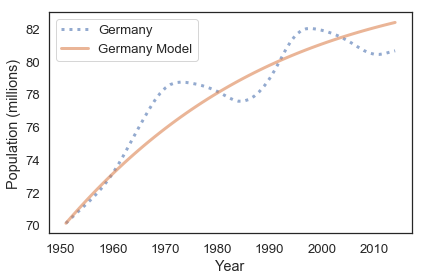

In [33]:
resultsg = run_simulation_g(system, update_func_quad_germany)

plot_results_g(germany, resultsg)

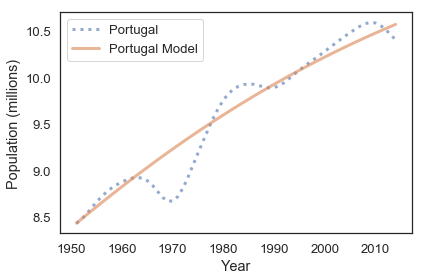

In [36]:
resultsp = run_simulation_p(system, update_func_quad_portugal)

plot_results_p(portugal, resultsp)

In [38]:
def get_relative_resid(real, model):
    results = TimeSeries()
    
    for t in linrange(get_first_label(real), get_last_label(real)):
        results[t] = (real[t] - model[t]) / real[t]
        
    return results

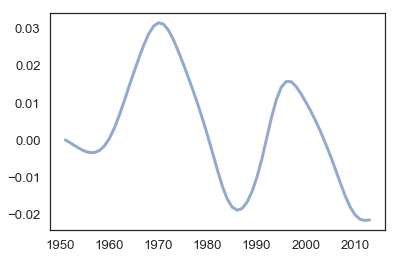

In [40]:
german_model = run_simulation_g(system, update_func_quad_germany)
german_resid = get_relative_resid(germany, german_model)

plot(german_resid)

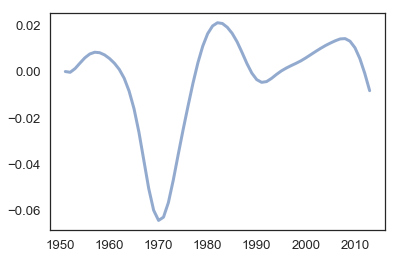

In [42]:
portuguese_model = run_simulation_p(system, update_func_quad_portugal)
portuguese_resid = get_relative_resid(portugal, portuguese_model)

plot(portuguese_resid)

Interpretation:
- German residuals are mostly positive, so our model is underestimating the German population by a bit
- Portuguese residuals are mostly negative, so our model is overestimating the Portuguese population by a bit
- The larger residual in Portugal was initially surprising, given that Portugal was one of seven countries sending workers to Germany, but is explained by Germany's significantly larger population.

In [44]:
def update_func_migrant_germany(pop, t, system):
    net_growth_germany=system.aG*pop*(system.maxG-pop)
    #Add line for migration
    #Does migration rate depend on time?
    return pop+net_growth_germany 

def update_func_migrant_portugal(pop, t, system):
    net_growth_portugal=system.aP*pop*(system.maxP-pop)
    return pop+net_growth_portugal

Next Steps:
- Create a model where we have a bunch of people go to Germany and leave after 3 years.
- Create a model where we have a bunch of people leave Portugal and come back after 3 years.
- Create a residual plot for our new models.
- Compare our new residual plot to our old residual plot.

In [92]:
def travel_popularity(t):
    pop =  -1*(t-1960)*(t-1973)/80 #5 year delay for program to become significantly popular
    if t <= 1960 or t >= 1973:
        return 0
    else:
        return pop

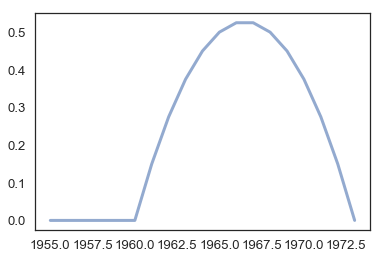

In [93]:
results = TimeSeries()
time = linrange(1955, 1974)
for t in time:
    results[t] = travel_popularity(t)
    
plot(results)

In [106]:
def update_func_migrant_germany(pop, t, system):
    
    net_growth_germany = system.aG*pop*(system.maxG-pop)
    net_growth_germany += travel_popularity(t)*system.c
    net_growth_germany -= travel_popularity(t-3)*system.c/1.5 
    #Research shows ~2/3 of people stayed in the country bc of the booming economy
    
    return pop+net_growth_germany 

def update_func_migrant_portugal(pop, t, system):
    
    net_growth_portugal = system.aP*pop*(system.maxP-pop)
    net_growth_portugal -= travel_popularity(t)*system.c/7
    net_growth_portugal += travel_popularity(t-3)*system.c/(1.5*7)
    #Portugal was one of seven countries sending workers to Germany
    
    return pop+net_growth_portugal

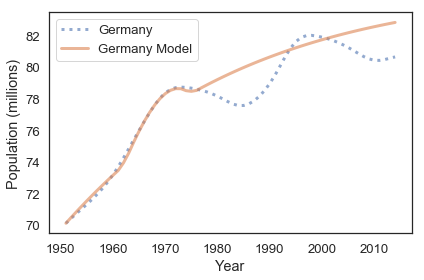

In [107]:
resultsg = run_simulation_g(system, update_func_migrant_germany)

plot_results_g(germany, resultsg)

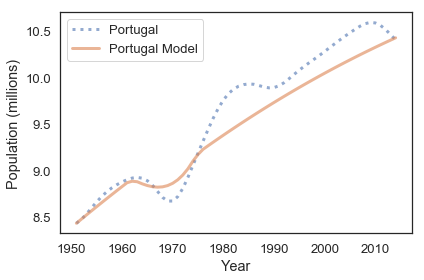

In [108]:
resultsp = run_simulation_p(system, update_func_migrant_portugal)

plot_results_p(portugal, resultsp)

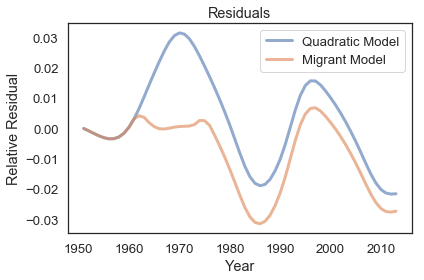

In [114]:
german_model_quad = run_simulation_g(system, update_func_quad_germany)
german_model_migrant = run_simulation_g(system, update_func_migrant_germany)

german_resid_quad = get_relative_resid(germany, german_model_quad)
german_resid_migrant = get_relative_resid(germany, german_model_migrant)


plot(german_resid_quad, label='Quadratic Model')
plot(german_resid_migrant, label='Migrant Model')

decorate(xlabel='Year', ylabel='Relative Residual', title='Residuals');

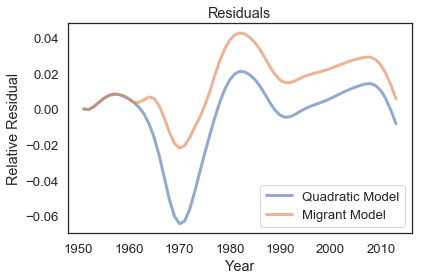

In [115]:
portuguese_model = run_simulation_p(system, update_func_quad_portugal)
portuguese_resid_quad = get_relative_resid(portugal, portuguese_model)

portuguese_model = run_simulation_p(system, update_func_migrant_portugal)
portuguese_resid_migrant = get_relative_resid(portugal, portuguese_model)

plot(portuguese_resid_quad, label='Quadratic Model')
plot(portuguese_resid_migrant, label='Migrant Model')

decorate(xlabel='Year', ylabel='Relative Residual', title='Residuals');

Interpretation:
- The quadratic growth model roughly approximated the population curve, though there were clearly variations in the population that were not accounted for in that model
    - This growth model, along with its residual plot, showed us when significant deviations in populations occurred
- The new model almost perfectly accounted for the change in Germany's population, and accounted for over half of the population decrease in Portugal
- Our migrant model was successful because in the time range 1955-1973, the residuals were significantly lower than those of a generic logistic model

- A few causes of error include:
    - We were unsure how many migrants workers stayed in Germany
    - We were unsure how the popularity of migration changed with time
    - We were unsure what percentage of the migrant workers in Germany came from Portugal


Sources

- www.rhinoresourcecenter.com/pdf_files/123/1236972547.pdf
- https://www.gapminder.org/data/
- http://countrystudies.us/germany/84.htm
    - "Originally brought in for three-year shifts, most workers--mainly single men--remained and made a valuable contribution to the booming West German economy." (2.5 million foreigners went to germany between 1955 and 1973)
    
- https://www.nytimes.com/1984/08/19/magazine/germany-s-guest-workers.html